In [1]:
# To install the library
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00


In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

In [3]:
# Importing functions from the above library
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima # Auto ML model

In [4]:
# Upload dataset - exchange_rate.csv
#Reading our dataset
df = pd.read_csv('exchange_rate.csv',parse_dates=["date"])
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


# **01. EDA**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [7]:
# Find out the null values
df.isnull().sum()

,0
date,0
Ex_rate,0


In [8]:
# Findout the duplicate values
df.duplicated().sum()

0

In [9]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
# Extracting Day, month name, year from the Date column using Date functions from pandas

In [10]:
df

,date,Ex_rate
0,1990-01-01,0.785500
1,1990-01-02,0.781800
2,1990-01-03,0.786700
3,1990-01-04,0.786000
4,1990-01-05,0.784900
...,...,...
7583,2010-10-06,0.718494
7584,2010-10-07,0.721839
7585,2010-10-08,0.723197
7586,2010-10-09,0.720825


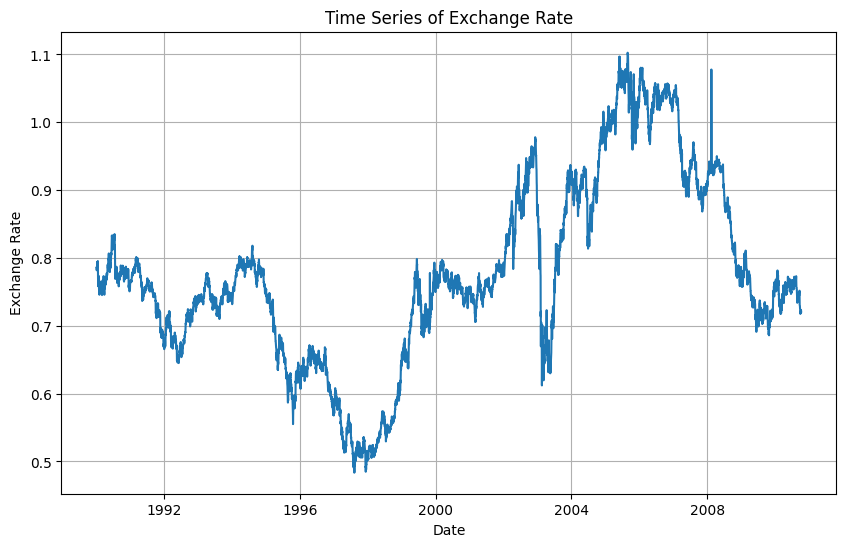

In [11]:
# Plot the time series for exchange rate
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['Ex_rate'])
plt.title('Time Series of Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [12]:
df.info() #Check the data type of the date column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


# **02. Model Building**

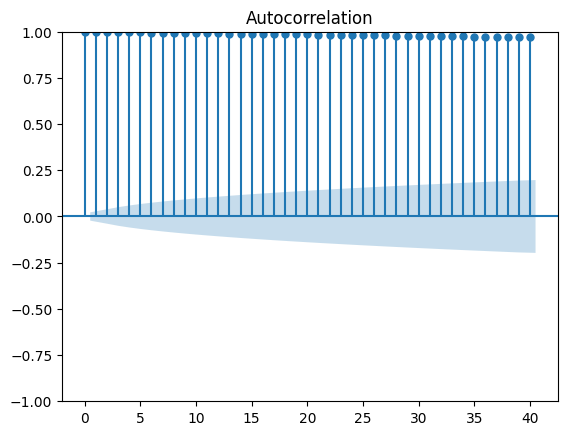

In [13]:
# ACF plots for parameter selection
plot_acf(df['Ex_rate'], lags=40)
plt.show()

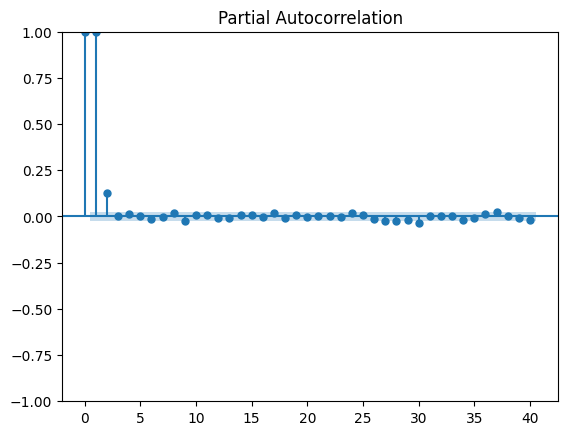

In [14]:
# PACF plot for parameter selection
plot_pacf(df['Ex_rate'], lags=40)
plt.show()

In [15]:
# Define the model
p, d, q = 1, 1, 1  # These values should be chosen based on ACF and PACF plots
a_model = ARIMA(df['Ex_rate'], order=(p, d, q))

# Fit the model
a_result = a_model.fit()

In [16]:
# Summary of the model
print(a_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Thu, 12 Sep 2024   AIC                         -56102.322
Time:                        02:11:21   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [17]:
a_result

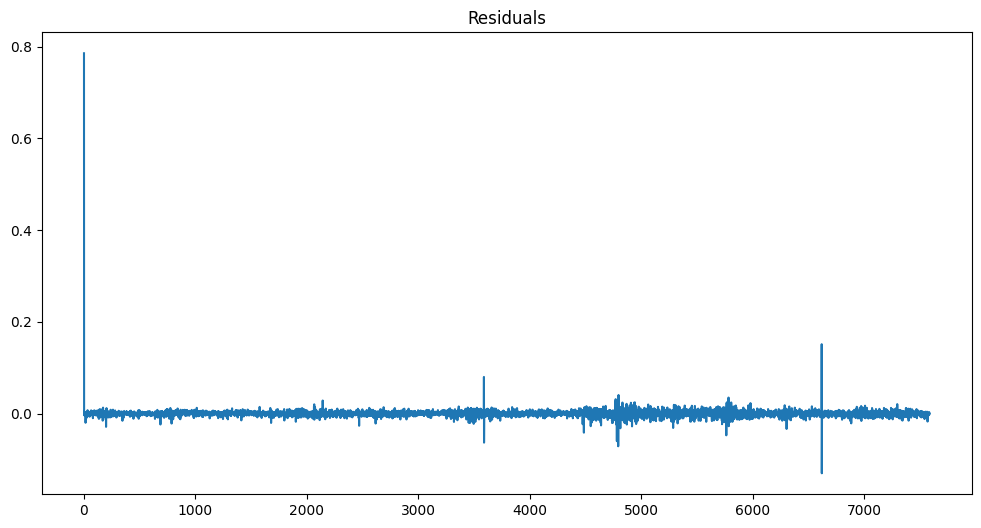

In [18]:
# Analyzing the residuals to ensure there are no patterns that might indicate model inadequacies
# Plotting the residuals
residuals = a_result.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

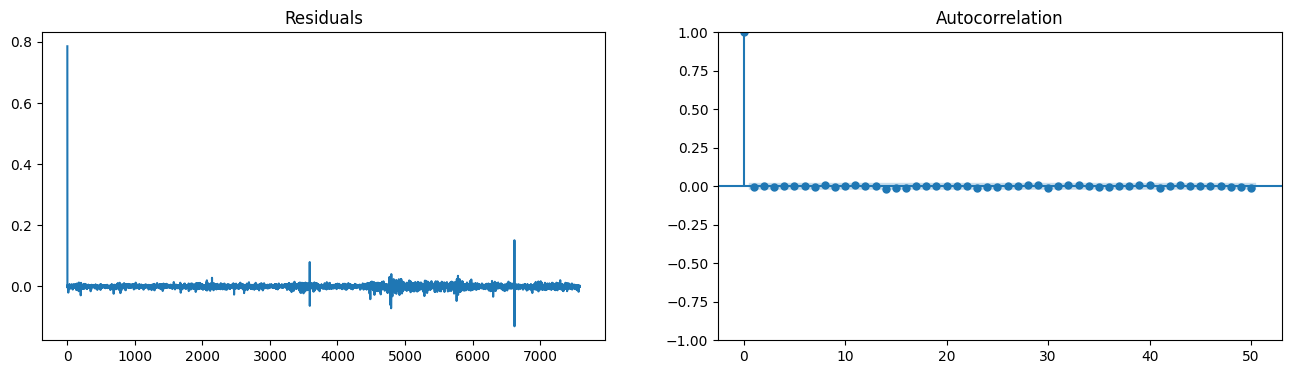

In [19]:
# Plotting ACF of the residuals
# Residual diagnostics
residuals = a_result.resid
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(residuals)
axes[0].set_title('Residuals')
plot_acf(residuals, lags=50, ax=axes[1])
plt.show()

# **03. Forecasting**

In [20]:
# Splitting the data into training and testing
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train_data, test_data = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]  # Splitting the data

In [21]:
# Fitting the model into training data
a_model = ARIMA(train_data, order=(p, d, q))
a_fit = a_model.fit()

In [28]:
# Forecasting for the next 3 days
forecast_steps = 3
forecast = a_fit.get_forecast(steps=forecast_steps)

In [29]:
forecast_ci = forecast.conf_int()

In [23]:
forecast

,predicted_mean
6070,1.023685
6071,1.023606
6072,1.023653


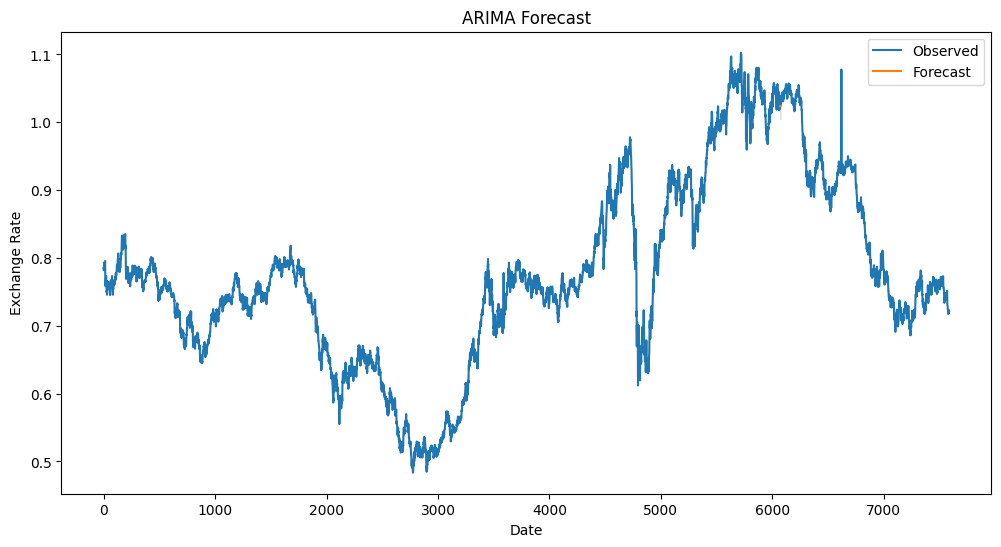

In [32]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [33]:
# Forecasting
forecast_steps = 30  # Number of steps to forecast
forecast = a_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

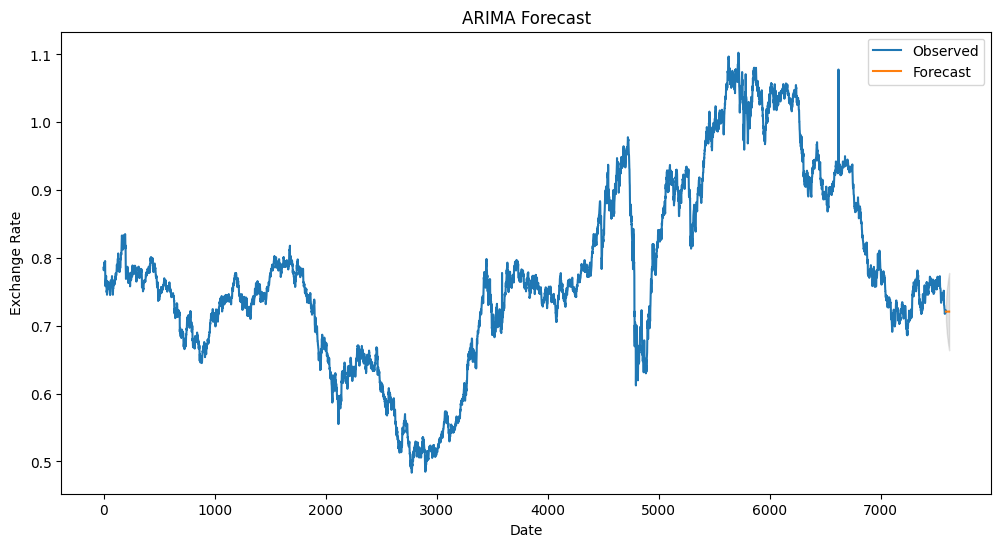

In [34]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# **04. Model Building - Exponential Smoothing**

In [35]:
# Decomposing the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

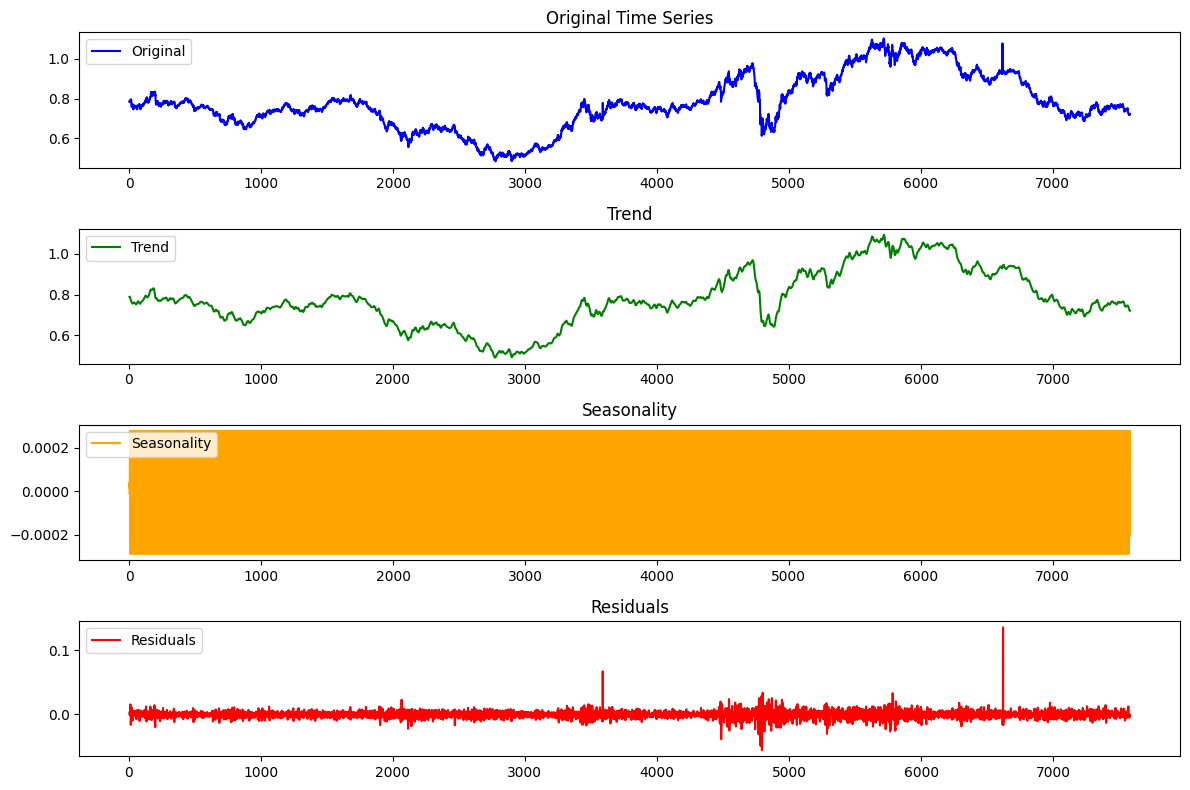

In [36]:
# Plotting the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Ex_rate'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='orange')
plt.legend(loc='upper left')
plt.title('Seasonality')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [37]:
# Define the model (Holt-Winters Exponential Smoothing)
exp_model = ExponentialSmoothing(df['Ex_rate'], seasonal='add', seasonal_periods=12)

# Fit the model
exp_result = exp_model.fit()

# Summary of the model
print(exp_result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.480
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Thu, 12 Sep 2024
Box-Cox:                          False   Time:                         02:43:15
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698356                alpha                 True
smoothing_seasonal       

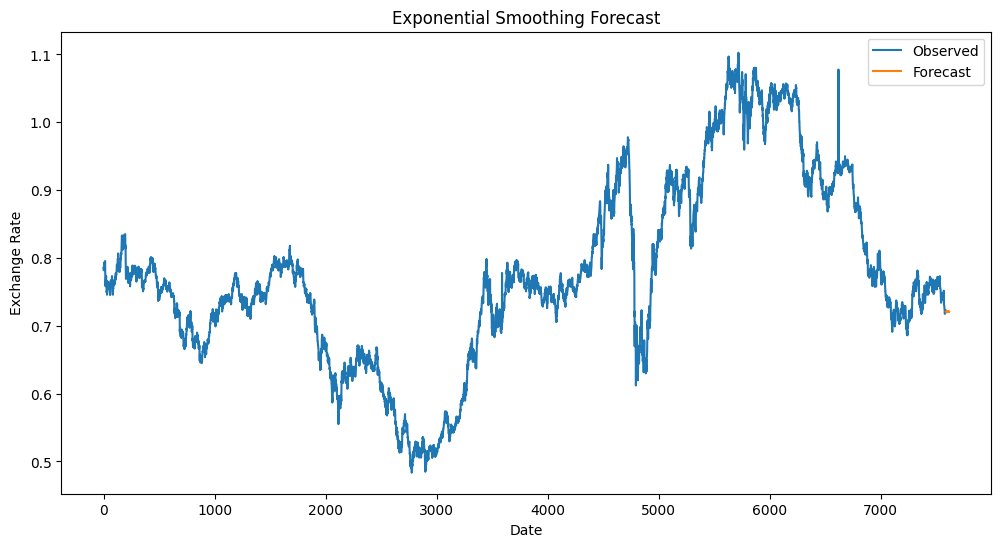

In [38]:
# Forecasting
exp_forecast = exp_result.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(exp_forecast, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# **05. Evaluation and Comparison**

In [39]:
# Compute error metrics for ARIMA
arima_forecast_values = forecast.predicted_mean
arima_mae = mean_absolute_error(df['Ex_rate'][-forecast_steps:], arima_forecast_values)
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-forecast_steps:], arima_forecast_values))
arima_mape = np.mean(np.abs((df['Ex_rate'][-forecast_steps:] - arima_forecast_values) / df['Ex_rate'][-forecast_steps:])) * 100

In [40]:
# Compute error metrics for Exponential Smoothing
exp_forecast_values = exp_forecast
exp_mae = mean_absolute_error(df['Ex_rate'][-forecast_steps:], exp_forecast_values)
exp_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-forecast_steps:], exp_forecast_values))
exp_mape = np.mean(np.abs((df['Ex_rate'][-forecast_steps:] - exp_forecast_values) / df['Ex_rate'][-forecast_steps:])) * 100

In [41]:
print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}%")
print(f"Exponential Smoothing MAE: {exp_mae}, RMSE: {exp_rmse}, MAPE: {exp_mape}%")

ARIMA MAE: 0.012724006489305202, RMSE: 0.016982710912755217, MAPE: nan%
Exponential Smoothing MAE: 0.012893873162132911, RMSE: 0.017130676033911125, MAPE: nan%


In [42]:
# Based on error metrics, we can see which model performs better

if arima_mae < exp_mae:
    print("ARIMA model performs better in terms of MAE.")
else:
    print("Exponential Smoothing model performs better in terms of MAE.")

if arima_rmse < exp_rmse:
    print("ARIMA model performs better in terms of RMSE.")
else:
    print("Exponential Smoothing model performs better in terms of RMSE.")

if arima_mape < exp_mape:
    print("ARIMA model performs better in terms of MAPE.")
else:
    print("Exponential Smoothing model performs better in terms of MAPE.")

ARIMA model performs better in terms of MAE.
ARIMA model performs better in terms of RMSE.
Exponential Smoothing model performs better in terms of MAPE.


Summary:

ARIMA and Exponential Smoothing models were compared for forecasting exchange rates

Error metrics (MAE, RMSE, MAPE) were used to evaluate the models

Arima performed slightly better than Exponential Smoothing method

A.  Arima Model

1. Advantages:

  • Flexibility:

    ARIMA can model a wide range of time series data, including both stationary and non-stationary data (via differencing).
    Can capture complex structures in data, like trends, seasonality (using SARIMA), and correlations in the residuals.

  • Incorporation of Autocorrelation:

    The AR and MA components allow ARIMA to capture autocorrelations (the relationship between observations over different time lags).

  • Strong Theoretical Foundation:

    ARIMA has a solid basis in statistical theory and is widely used for forecasting purposes in various domains like finance, economics, and supply chain management.

  • Diagnostic Tools:

    ACF and PACF plots, along with residual diagnostics, offer clear ways to test and improve model performance.

  • Widely Used and Understood:

    ARIMA is a well-established method with clear guidelines on implementation, and tools for evaluation such as the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).

2. Limitations:
  
  • Stationarity Requirement:

    ARIMA models work best with stationary data (data where statistical properties like mean and variance do not change over time). You often need to apply differencing or transformations to make the series stationary.

  • Lack of Support for Multiple Variables:

    ARIMA is univariate, meaning it only handles single-variable time series data. For multivariate forecasting (using multiple predictors), other models like VAR (Vector AutoRegression) are required.
  
  • Complexity with Seasonal Data:

    Although seasonal ARIMA (SARIMA) models exist, adding seasonal components increases model complexity and can make model selection harder.

  • Long-Term Forecasting Limitations:

    ARIMA is generally better for short- to medium-term forecasting. Over long periods, errors can accumulate, and it becomes less reliable, especially for series with strong trends or seasonality.

  • Parameter Tuning Can Be Tricky:

    Selecting appropriate values for the parameters (p, d, q) using ACF and PACF plots can be subjective and time-consuming.

B. Exponential smoothing

1. Advantages:

  • Simplicity:

    Exponential smoothing models (e.g., Simple, Holt’s, and Holt-Winters) are easy to implement and interpret. They provide straightforward mechanisms for forecasting time series with trends and seasonality.
  
  • Efficient for Short-Term Forecasting:

    These models are particularly effective for short-term forecasting, especially when the time series contains little noise.

  • Automatically Weights Recent Data:

    Exponential smoothing gives more weight to recent observations, which makes it particularly effective when the most recent data points are more relevant for future predictions.
  
  • Can Handle Seasonality:

    Models like Holt-Winters (Triple Exponential Smoothing) can handle time series data with both trend and seasonality components.

  • Fewer Assumptions:

    Exponential smoothing models make fewer assumptions about the underlying structure of the data compared to ARIMA, which requires stationarity.

  • Fast to Train:

    These models are computationally simple and quick to fit, making them useful when you need to generate forecasts quickly.

2. Limitations:

  • Limited Flexibility:

    Exponential smoothing models may not capture complex relationships in time series data, such as autocorrelation or sudden shifts in the time series, as well as ARIMA.

  • Only Recent Data Matters:

    Since these models weigh recent observations more heavily, they may not be suitable for data where long-term trends or distant historical values are important.

  • Does Not Account for Autocorrelation:

    Unlike ARIMA, exponential smoothing models don’t explicitly model the autocorrelation between observations. This can lead to underperformance when autocorrelation is a significant factor in the data.
  
  • Struggles with Complex Patterns:

    While Holt-Winters can handle trends and seasonality, it may struggle with more complex time series patterns or structural changes in the data.

  • Not Good for Long-Term Forecasting:

    Exponential smoothing is mainly useful for short- to medium-term forecasts. As with ARIMA, forecast accuracy declines over longer horizons, especially for non-stationary data.

  • Sensitive to Hyperparameters:

    Finding the optimal smoothing parameters (alpha, beta, gamma) can be challenging. Poor parameter selection can result in inaccurate forecasts.


In [18]:
# Alternatively, Instead of creating ACF and PACF plots, we can use an auto ML
# In the below code where we are using auto ARIMA, it'll be giving us the values of (P,D,Q) along with seasonality.
# The m stands for month wise seasonality
# Note that it is capital P,D & Q and not small p,d & q. This is because when seasonality is introduced ARIMA(p,d,q) becomes ARIMA (P,D,Q,m)
# and these models are called SARIMA models

In [1]:
'''# Fit auto_arima function to Exchange rate dataset
stepwise_fit = auto_arima(df['Ex_rate'], start_p = 1, start_q = 1, # We are mentioning some values for p and q and giving a range to find out the best value
						max_p = 3, max_q = 3, m = 12,
						start_P = 0, seasonal = True, # We are also checking for some seasonality in our data
						d = None, D = 1, trace = True,
						error_action ='ignore', # we don't want to know if an order does not work
						suppress_warnings = True, # we don't want convergence warnings
						stepwise = True)		 # set to stepwise

# To print the summary
stepwise_fit.summary()'''

"# Fit auto_arima function to Exchange rate dataset\nstepwise_fit = auto_arima(df['Ex_rate'], start_p = 1, start_q = 1, # We are mentioning some values for p and q and giving a range to find out the best value\n\t\t\t\t\t\tmax_p = 3, max_q = 3, m = 12,\n\t\t\t\t\t\tstart_P = 0, seasonal = True, # We are also checking for some seasonality in our data\n\t\t\t\t\t\td = None, D = 1, trace = True,\n\t\t\t\t\t\terror_action ='ignore', # we don't want to know if an order does not work\n\t\t\t\t\t\tsuppress_warnings = True, # we don't want convergence warnings\n\t\t\t\t\t\tstepwise = True)\t\t # set to stepwise\n\n# To print the summary\nstepwise_fit.summary()"